In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(12)
b = a + a
b

Value(data=24)

In [ ]:
print(b)

Value(data=24)


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
import math

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


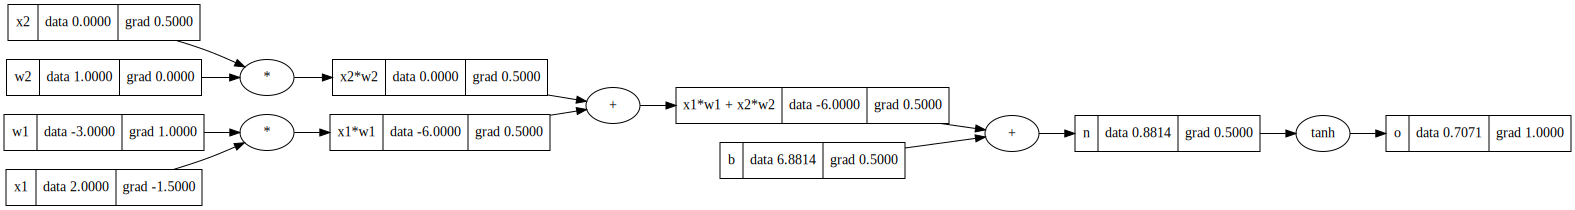

In [ ]:
draw_dot(o)

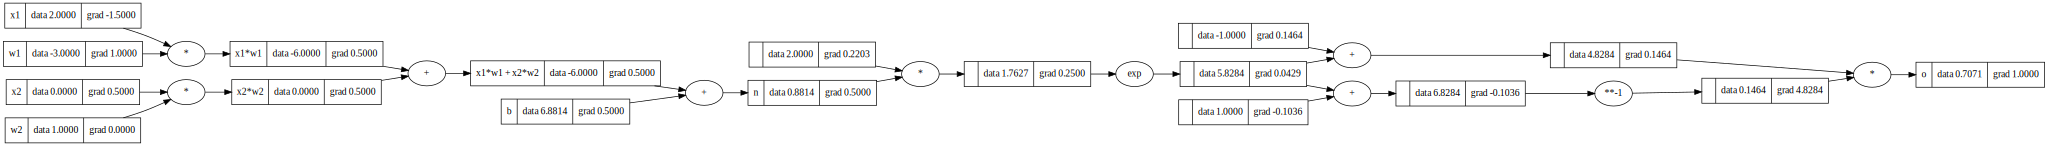

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

# torch

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1), label='W') for _ in range(nin)]
    self.b = Value(random.uniform(-1,1), label='b')

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
nnn = Neuron(2)
print("====WEIGHTS====")
print(nnn.w)
print("====BIAS====")
print(nnn.b)

====WEIGHTS====
[Value(data=-0.48030856424661295), Value(data=0.32694422853884)]
====BIAS====
Value(data=-0.8363923232590984)


In [ ]:
nnn = Neuron(nin=2)
print("====WEIGHTS====")
print(nnn.w)
print("====BIAS====")
print(nnn.b)

====WEIGHTS====
[Value(data=0.31645469583954755), Value(data=-0.5332460127371925)]
====BIAS====
Value(data=0.055824091510714435)


In [ ]:
import random

In [ ]:
x = [Value(2.0, label="A"), Value(3.0, label="B"), Value(-1.0, label="C")]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.13195491314978372)

In [ ]:
n

In [ ]:
graph = draw_dot(n(x))
graph.render('neuron_computation_graph', view=True, cleanup=True)

'neuron_computation_graph.svg'

In [ ]:
n.parameters()

[Value(data=0.00586595351892738),
 Value(data=-0.777744403527532),
 Value(data=-0.6463153787914646),
 Value(data=-0.248958525960971),
 Value(data=0.40637436490259127),
 Value(data=0.9566395701328207),
 Value(data=-0.8171694463230659),
 Value(data=-0.7119002749186563),
 Value(data=-0.10440088654670787),
 Value(data=0.7741494872019965),
 Value(data=0.44120447419887254),
 Value(data=-0.9795139427377773),
 Value(data=-0.14060613003683464),
 Value(data=-0.49842926504493557),
 Value(data=-0.3803551851818012),
 Value(data=0.8344254961127671),
 Value(data=0.3067678937566771),
 Value(data=-0.2422919727674413),
 Value(data=-0.11926888398515856),
 Value(data=-0.47542038864783587),
 Value(data=0.04792347098116867),
 Value(data=-0.2067086696633449),
 Value(data=-0.7961801801991892),
 Value(data=-0.8700365404369355),
 Value(data=-0.06414169483094789),
 Value(data=-0.5779548655145059),
 Value(data=0.6817881046128564),
 Value(data=-0.3229522885130365),
 Value(data=0.6268937871554616),
 Value(data=-0.8

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 3.1795124004892195
1 2.228715579676264
2 2.5869485635833764
3 1.4255650290431632
4 1.668077890954251
5 0.14586851943408596
6 0.06175343726062758
7 0.049572695525734276
8 0.04300448952411312
9 0.038552136023239675
10 0.03517490914694772
11 0.03244843532291933
12 0.030163553933216396
13 0.028202181367551357
14 0.02649045822099437
15 0.02497845394886331
16 0.023630381649542793
17 0.02241944193690173
18 0.021324891843178033
19 0.02033026632329587


In [ ]:
ypred

[Value(data=0.9447842424582511),
 Value(data=-0.9713990791217514),
 Value(data=-0.9307245001853558),
 Value(data=0.9214056746254079)]